## Hele-Shaw Flow Exponential Disorder MC Integrator

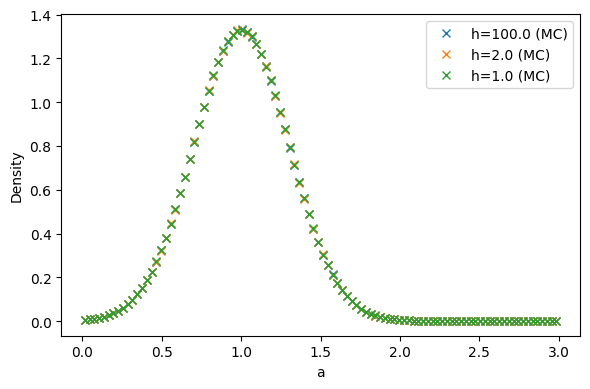

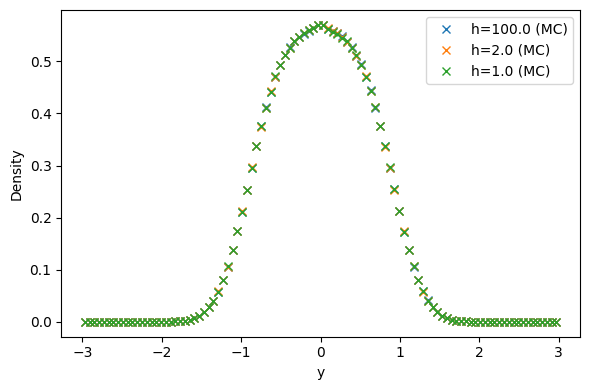

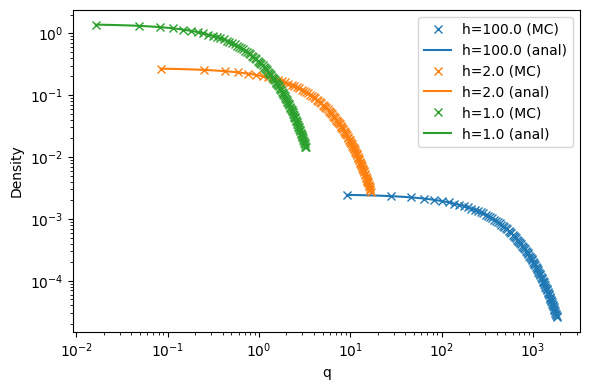

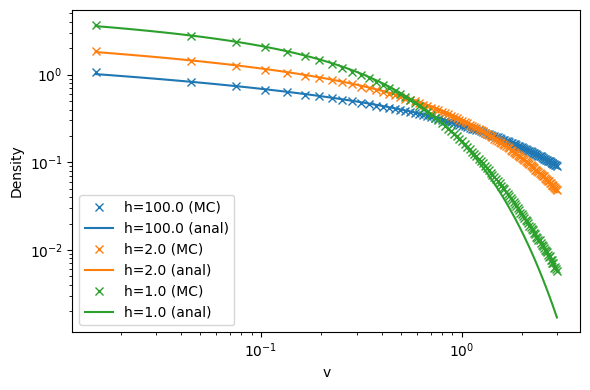

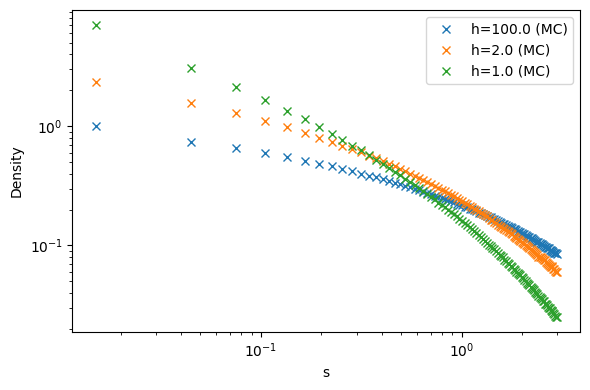

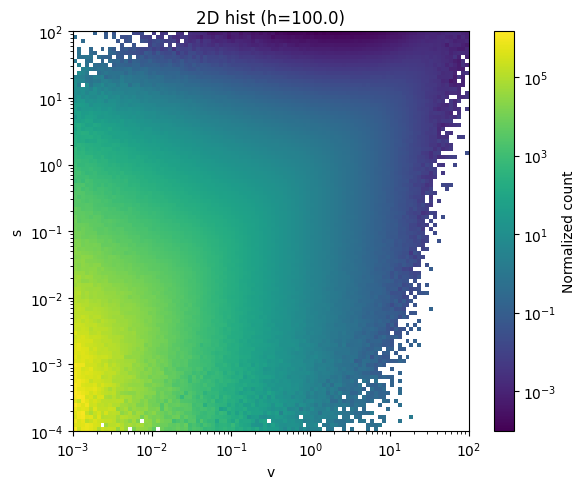

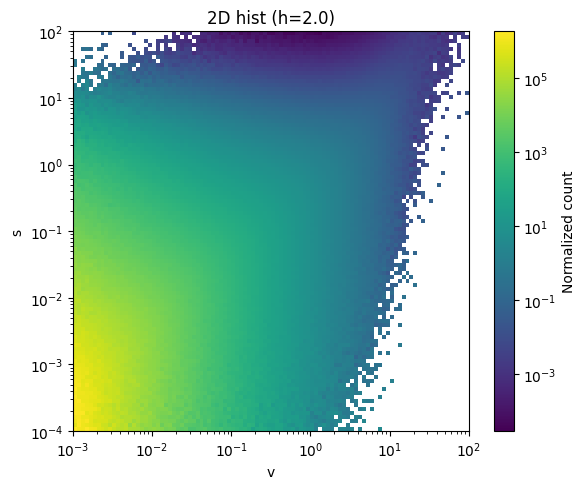

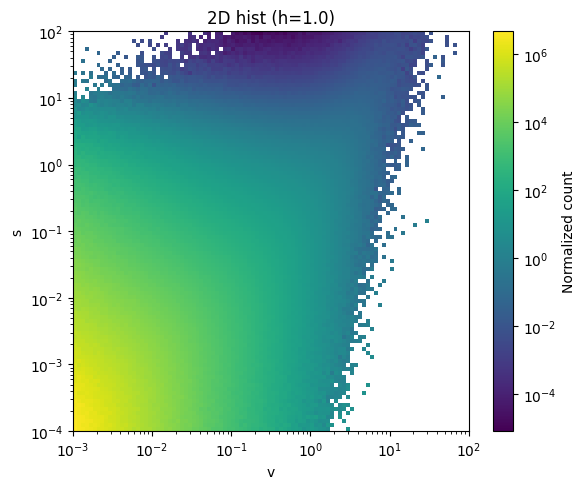

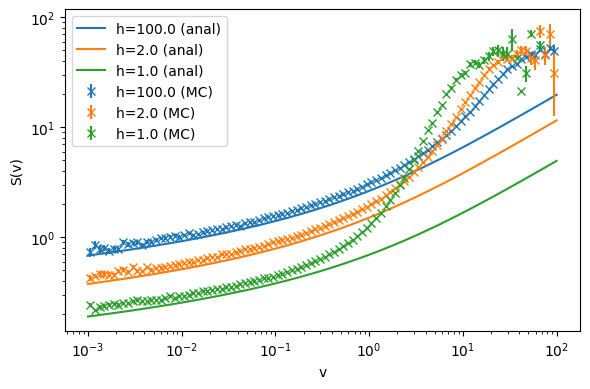

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from matplotlib.colors import LogNorm


# Monte Carlo parameters and RNG:

rng    = np.random.default_rng()
NMCS   = 10**7    # number of samples
NBINS  = 100      # bins for histograms
eps    = 0.3      # standard deviation for 'a'
# Different heights of the Hele-Shaw cell
hs     = [100.0, 2.0, 1.0]

# Pre-allocate arrays
n_cases = len(hs)
a       = np.empty((n_cases, NMCS))
q       = np.empty((n_cases, NMCS))
y       = np.empty((n_cases, NMCS))
v       = np.empty((n_cases, NMCS))
s       = np.empty((n_cases, NMCS))
g       = np.empty((n_cases, NMCS))
weights = np.ones(NMCS)

# Sample a, q, y, v, s
for i, h in enumerate(hs):
    # 1) a ~ Normal(μ=1, σ=eps), reject a<=0
    ai = rng.normal(loc=1.0, scale=eps, size=NMCS)
    if eps > 0:
        while np.any(ai <= 0):
            mask = ai <= 0
            ai[mask] = rng.normal(loc=1.0, scale=eps, size=mask.sum())
    a[i] = ai

    # geometry parameter
    r = h / np.sqrt(12.0)

    # 2) q ~ Exponential
    Qc = (h**3)*(1.0-np.tanh(1.0/r)*r)
    q[i] = rng.exponential(scale= Qc, size=NMCS)
    # (we scale fluxes with h so that G_c doesnt change)


    # 3) y ~ Uniform[-a, +a]
    y[i] = (2.0 * rng.random(NMCS) - 1.0) * a[i]

    # 4) velocity v and shear s (Brinkman profile)
    g[i] = 6.0*q[i]/((h**3)*a[i]*(1.0-np.tanh(a[i]/r)*(r/a[i])))
    cosh1 = np.cosh(a[i]/r)
    v[i] = g[i]*r*r*(1.0 - np.cosh(y[i]/r) / cosh1)
    s[i] = g[i]*r*np.abs(np.sinh(y[i]/r)) / cosh1

# Helper: 1D histogram
def compute_histogram(data, nbins, min_val, max_val):
    hist, edges = np.histogram(
        data, bins=nbins, range=(min_val, max_val), weights=weights
    )
    width   = (max_val - min_val) / nbins
    density = hist / (weights.sum() * width)
    centers = edges[:-1] + width/2
    return density, centers

# Build histogram data
data_vars = ['a', 'y', 'q', 'v', 's']
data = {'a': a, 'y': y, 'q': q, 'v': v, 's': s}

# define ranges
default_min, default_max = 0.0, 3.0
min_vals = {var: default_min for var in data_vars}
max_vals = {var: default_max for var in data_vars}
min_vals['y'] = -default_max; max_vals['y'] = default_max
# q-range by 99th percentile
max_vals['q'] = [np.percentile(q[i], 99) for i in range(n_cases)]

histograms  = {var: [None]*n_cases for var in data_vars}
bin_centers = {var: [None]*n_cases for var in data_vars}

for var in data_vars:
    for i in range(n_cases):
        mn = min_vals[var]
        mx = max_vals[var][i] if var=='q' else max_vals[var]
        hst, bc = compute_histogram(data[var][i], NBINS, mn, mx)
        histograms[var][i]  = hst
        bin_centers[var][i] = bc

# 2D histograms (v,s) and shear|v
v_min, v_max = 1e-3, 100.0
s_min, s_max = 1e-4, 100.0
v_bins = np.geomspace(v_min, v_max, NBINS+1)
s_bins = np.geomspace(s_min, s_max, NBINS+1)
v_centers = np.sqrt(v_bins[:-1]*v_bins[1:])
s_centers = np.sqrt(s_bins[:-1]*s_bins[1:])
v_ratio = (v_max/v_min)**(1/NBINS)
s_ratio = (s_max/s_min)**(1/NBINS)
dv = v_bins[:-1]*(v_ratio-1)
ds = s_bins[:-1]*(s_ratio-1)

H           = np.zeros((n_cases, NBINS, NBINS))
H_true      = np.zeros_like(H)
H_err       = np.zeros_like(H)
H_norm      = np.zeros_like(H)
shear_v     = np.zeros((n_cases, NBINS))
shear_v_err = np.zeros_like(shear_v)

for i in range(n_cases):
    H[i],      _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights=weights)
    H_true[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights=s[i]*weights)
    H_err[i],  _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights=(s[i]**2)*weights)

    row_sums = H[i].sum(axis=1)
    mask     = row_sums>0
    H_norm[i][mask] = H[i][mask]/(row_sums[mask,None]*dv[mask,None]*ds[None,:])

    sum_true = H_true[i].sum(axis=1)
    sum_err  = H_err[i].sum(axis=1)
    shear_v[i][mask]     = sum_true[mask]/row_sums[mask]
    var_cond             = np.maximum(0, sum_err[mask]/row_sums[mask] - shear_v[i][mask]**2)
    shear_v_err[i][mask] = np.sqrt(var_cond/row_sums[mask])

# Analytical functions

w_c = 3

def analytical_q_exp(x, h):
    x = np.array(x)
    return np.where(x>=0, (1.0/h)*np.exp(-x/h), 0.0)


def analytical_Pv(v_vals, r, w_c):
    a = 1.0; ratio = a/r
    coth = lambda x: mp.cosh(x)/mp.sinh(x)
    sinh2 = lambda x: mp.sinh(x)**2
    prefac = (ratio * coth(ratio)) / (2 * w_c)
    C = 0.5*(mp.cosh(ratio)/sinh2(ratio))*ratio**2/w_c
    out = []
    for v in v_vals:
        out.append(float(prefac * mp.exp(-2.0*w_c*(prefac**2)*v) * mp.besselk(0, C*v)))
    return np.array(out)


def analytical_S(v_vals, r, w_c):
    a = 1.0; ratio = a/r
    tanh_r = mp.tanh(ratio)
    cosh_r = mp.cosh(ratio)
    sinh_r2 = mp.sinh(ratio)**2
    prefac = (2*w_c/a)*(r/a)*tanh_r
    C = 0.5*(cosh_r/sinh_r2)*ratio**2/w_c
    out = []
    for v in v_vals:
        out.append(float(prefac * mp.exp(-C*v) / mp.besselk(0, C*v)))
    return np.array(out)

# ------------------------------------------------
# Plotting routines
# ------------------------------------------------
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
log_binning = True

# 1D histograms + analytical
for var in data_vars:
    plt.figure(figsize=(6,4))
    for i, h in enumerate(hs):
        mc = histograms[var][i]
        bc = bin_centers[var][i]
        plt.plot(bc, mc, 'x', color=colors[i], label=f'h={h} (MC)')

        r = h/np.sqrt(12.0)
        Qc = (h**3)*(1.0-np.tanh(1.0/r)*r)
        if var=='q':
            x_range = np.logspace(np.log10(bc[0]), np.log10(bc[-1]), NBINS)
            y_ana = analytical_q_exp(x_range, Qc)
            plt.plot(x_range, y_ana, '-', color=colors[i], label=f'h={h} (anal)')
        elif var=='v':
            r = hs[i]/np.sqrt(12.0)
            x_range = np.logspace(np.log10(bc[0]), np.log10(bc[-1]), NBINS)
            y_ana = analytical_Pv(x_range, r, w_c)
            plt.plot(x_range, y_ana, '-', color=colors[i], label=f'h={h} (anal)')

    plt.xlabel(var)
    plt.ylabel('Density')
    if var in ('a','y'):
        plt.xscale('linear'); plt.yscale('linear')
    else:
        if log_binning:
            plt.xscale('log'); plt.yscale('log')
        else:
            plt.xscale('linear'); plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2D histograms
for i, h in enumerate(hs):
    fig, ax = plt.subplots(figsize=(6,5))
    mesh = ax.pcolormesh(v_bins, s_bins, H_norm[i].T,
                         shading='auto', cmap='viridis',
                         norm=LogNorm())
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('v'); ax.set_ylabel('s')
    ax.set_title(f'2D hist (h={h})')
    fig.colorbar(mesh, ax=ax, label='Normalized count')
    plt.tight_layout(); plt.show()

# Shear vs velocity
plt.figure(figsize=(6,4))
for i, h in enumerate(hs):
    r = h/np.sqrt(12.0)
    # MC
    plt.errorbar(v_centers, shear_v[i], yerr=shear_v_err[i],
                 fmt='x', color=colors[i], label=f'h={h} (MC)')
    # analytical S
    x_range = np.logspace(np.log10(v_min), np.log10(v_max), NBINS)
    y_ana = analytical_S(x_range, r, w_c)
    plt.plot(x_range, y_ana, '-', color=colors[i], label=f'h={h} (anal)')

plt.xscale('log'); plt.yscale('log')
plt.xlabel('v'); plt.ylabel('S(v)')
plt.legend(); plt.tight_layout(); plt.show()
